In [10]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.autograd import Function
import torch.backends.cudnn as cudnn
import os
import numpy as np
from tqdm import tqdm
from model import FaceModel
from eval_metrics import evaluate
from TripletFaceDataset import TripletFaceDataset
from LFWDataset import LFWDataset
from PIL import Image
from utils import PairwiseDistance,display_triplet_distance,display_triplet_distance_test
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [11]:
class TripletMarginLoss(Function):
    """Triplet loss function.
    """
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(anchor, positive)
        d_n = self.pdist.forward(anchor, negative)

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss

In [12]:
class Scale(object):
    """Rescales the input PIL.Image to the given 'size'.
    If 'size' is a 2-element tuple or list in the order of (width, height), it will be the exactly size to scale.
    If 'size' is a number, it will indicate the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the exactly size or the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), self.interpolation)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), self.interpolation)
        else:
            return img.resize(self.size, self.interpolation)

In [13]:
def train_epoch(train_loader, model, optimizer):
    #训练模型
    pbar = tqdm(enumerate(train_loader))
    labels, distances = [], []

    for batch_idx, (data_a, data_p, data_n,label_p,label_n) in pbar:
        #gpu模式
        #data_a, data_p, data_n = data_a.cuda(), data_p.cuda(), data_n.cuda()

        # compute output
        out_a, out_p, out_n = model(data_a), model(data_p), model(data_n)

        # Choose the hard negatives
        d_p = l2_dist.forward(out_a, out_p)
        d_n = l2_dist.forward(out_a, out_n)
        #
        all = (d_n - d_p < 0.5).numpy().flatten()
        hard_triplets = np.where(all == 1)
        if len(hard_triplets[0]) == 0:
            continue
        out_selected_a = out_a[hard_triplets]
        out_selected_p = out_p[hard_triplets]
        out_selected_n = out_n[hard_triplets]

        selected_data_a = data_a[hard_triplets]
        selected_data_p = data_p[hard_triplets]
        selected_data_n = data_n[hard_triplets]

        selected_label_p = label_p[hard_triplets]
        selected_label_n= label_n[hard_triplets]
        
        triplet_loss = TripletMarginLoss(0.5).forward(out_selected_a, out_selected_p, out_selected_n)

        cls_a = model.forward_classifier(selected_data_a)
        cls_p = model.forward_classifier(selected_data_p)
        cls_n = model.forward_classifier(selected_data_n)

        criterion = nn.CrossEntropyLoss()
        predicted_labels = torch.cat([cls_a,cls_p,cls_n])
        true_labels = torch.cat((selected_label_p,selected_label_p,selected_label_n))

        cross_entropy_loss = criterion(predicted_labels,true_labels)

        loss = cross_entropy_loss + triplet_loss
        
        # compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log loss value
        if batch_idx%10 ==0:
            print(loss)

        dists = l2_dist.forward(out_selected_a,out_selected_n) #torch.sqrt(torch.sum((out_a - out_n) ** 2, 1))  # euclidean distance
        distances.append(dists.detach().numpy())
        labels.append(np.zeros(dists.size(0)))

        dists = l2_dist.forward(out_selected_a,out_selected_p)#torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.detach().numpy())
        labels.append(np.ones(dists.size(0)))

    labels = np.array([sublabel for label in labels for sublabel in label])
    distances = np.array([subdist for dist in distances for subdist in dist])

    tpr, fpr, accuracy, val, val_std, far = evaluate(distances,labels)
    print('\33[91mTrain set: Accuracy: {:.8f}\n\33[0m'.format(np.mean(accuracy)))

    plot_roc(fpr,tpr,figure_name="roc_train.png")


In [14]:
def test(test_loader, model):
    #测试
    model.eval()
    labels, distances = [], []

    pbar = tqdm(enumerate(test_loader))
    for batch_idx, (data_a, data_p, label) in pbar:
        # compute output
        out_a, out_p = model(data_a), model(data_p)
        dists = l2_dist.forward(out_a,out_p)#torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.numpy())
        labels.append(label.numpy())

        if batch_idx % args.log_interval == 0:
            pbar.set_description('Test Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data_a), len(test_loader.dataset),
                100. * batch_idx / len(test_loader)))

    labels = np.array([sublabel for label in labels for sublabel in label])
    distances = np.array([subdist for dist in distances for subdist in dist])

    tpr, fpr, accuracy, val, val_std, far = evaluate(distances,labels)
    print('\33[91mTest set: Accuracy: {:.8f}\n\33[0m'.format(np.mean(accuracy)))
    plot_roc(fpr,tpr,figure_name="roc_test_epoch_{}.png".format(epoch))

def plot_roc(fpr,tpr,figure_name="roc.png"):

    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

In [49]:
l2_dist = PairwiseDistance(2)
transform = transforms.Compose([
                         Scale(96),
                         transforms.ToTensor()])

In [16]:
train_dir = TripletFaceDataset(dir='lfw/train',n_triplets=10000,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dir,
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    LFWDataset(dir='lfw/test',pairs_path = 'lfw_pairs.txt', transform=transform),
    batch_size=64, shuffle=False)

  9%|▉         | 900/10000 [00:00<00:01, 8998.64it/s]

Generating 10000 triplets


100%|██████████| 6000/6000 [00:00<00:00, 14288.60it/s]


In [25]:
model = FaceModel(embedding_size=100,
                num_classes=len(train_dir.classes),
                pretrained=False)

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

1it [00:20, 20.69s/it]

tensor(9.6354, grad_fn=<AddBackward0>)


11it [03:41, 19.97s/it]

tensor(9.6940, grad_fn=<AddBackward0>)


21it [07:05, 20.35s/it]

tensor(10.4170, grad_fn=<AddBackward0>)


31it [10:24, 20.15s/it]

tensor(9.7669, grad_fn=<AddBackward0>)


41it [13:42, 19.44s/it]

tensor(9.6662, grad_fn=<AddBackward0>)


51it [16:47, 18.31s/it]

tensor(10.1950, grad_fn=<AddBackward0>)


61it [19:49, 17.72s/it]

tensor(9.9472, grad_fn=<AddBackward0>)


71it [22:40, 17.13s/it]

tensor(9.5330, grad_fn=<AddBackward0>)


81it [25:32, 17.51s/it]

tensor(9.4783, grad_fn=<AddBackward0>)


91it [28:28, 17.68s/it]

tensor(9.5278, grad_fn=<AddBackward0>)


101it [31:19, 16.96s/it]

tensor(9.2786, grad_fn=<AddBackward0>)


111it [34:07, 16.95s/it]

tensor(9.3342, grad_fn=<AddBackward0>)


121it [36:56, 16.88s/it]

tensor(9.3054, grad_fn=<AddBackward0>)


131it [39:43, 16.67s/it]

tensor(9.2390, grad_fn=<AddBackward0>)


141it [42:24, 15.99s/it]

tensor(9.0615, grad_fn=<AddBackward0>)


151it [45:04, 16.13s/it]

tensor(8.9823, grad_fn=<AddBackward0>)


157it [46:29, 17.77s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.52090580



1it [00:16, 16.01s/it]

tensor(8.5740, grad_fn=<AddBackward0>)


11it [02:57, 15.90s/it]

tensor(9.0340, grad_fn=<AddBackward0>)


21it [05:32, 15.75s/it]

tensor(8.9609, grad_fn=<AddBackward0>)


31it [08:13, 15.82s/it]

tensor(8.9797, grad_fn=<AddBackward0>)


41it [10:50, 15.68s/it]

tensor(8.6957, grad_fn=<AddBackward0>)


51it [13:22, 15.18s/it]

tensor(8.6814, grad_fn=<AddBackward0>)


61it [15:54, 15.27s/it]

tensor(8.4147, grad_fn=<AddBackward0>)


71it [18:26, 15.23s/it]

tensor(8.9908, grad_fn=<AddBackward0>)


81it [20:59, 15.25s/it]

tensor(9.0175, grad_fn=<AddBackward0>)


91it [23:34, 15.38s/it]

tensor(8.7195, grad_fn=<AddBackward0>)


101it [26:07, 15.08s/it]

tensor(8.7159, grad_fn=<AddBackward0>)


111it [28:35, 14.69s/it]

tensor(8.9886, grad_fn=<AddBackward0>)


121it [31:03, 15.19s/it]

tensor(8.9659, grad_fn=<AddBackward0>)


131it [33:30, 14.59s/it]

tensor(8.7202, grad_fn=<AddBackward0>)


141it [35:55, 14.53s/it]

tensor(8.8440, grad_fn=<AddBackward0>)


151it [38:24, 14.76s/it]

tensor(8.3517, grad_fn=<AddBackward0>)


157it [39:47, 15.20s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.49052676



1it [00:15, 15.20s/it]

tensor(8.2040, grad_fn=<AddBackward0>)


11it [02:40, 14.41s/it]

tensor(8.4947, grad_fn=<AddBackward0>)


21it [05:01, 13.92s/it]

tensor(8.3932, grad_fn=<AddBackward0>)


31it [07:20, 14.06s/it]

tensor(8.3472, grad_fn=<AddBackward0>)


41it [09:39, 13.97s/it]

tensor(8.0446, grad_fn=<AddBackward0>)


51it [12:03, 14.35s/it]

tensor(8.1677, grad_fn=<AddBackward0>)


61it [14:28, 14.20s/it]

tensor(8.5530, grad_fn=<AddBackward0>)


71it [16:49, 14.18s/it]

tensor(8.5067, grad_fn=<AddBackward0>)


81it [19:09, 13.89s/it]

tensor(8.1622, grad_fn=<AddBackward0>)


91it [21:27, 13.97s/it]

tensor(8.3587, grad_fn=<AddBackward0>)


101it [23:47, 13.96s/it]

tensor(8.3195, grad_fn=<AddBackward0>)


111it [26:04, 13.68s/it]

tensor(8.3090, grad_fn=<AddBackward0>)


121it [28:23, 14.08s/it]

tensor(8.2129, grad_fn=<AddBackward0>)


131it [30:43, 13.74s/it]

tensor(8.4058, grad_fn=<AddBackward0>)


141it [32:59, 13.94s/it]

tensor(8.5607, grad_fn=<AddBackward0>)


151it [35:20, 13.91s/it]

tensor(8.1516, grad_fn=<AddBackward0>)


157it [36:33, 13.97s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.49189060



1it [00:13, 13.22s/it]

tensor(7.2354, grad_fn=<AddBackward0>)


11it [02:25, 13.26s/it]

tensor(8.4025, grad_fn=<AddBackward0>)


21it [04:37, 13.15s/it]

tensor(7.0538, grad_fn=<AddBackward0>)


31it [06:50, 13.45s/it]

tensor(6.8914, grad_fn=<AddBackward0>)


41it [09:03, 13.17s/it]

tensor(7.7159, grad_fn=<AddBackward0>)


51it [11:22, 13.88s/it]

tensor(7.5280, grad_fn=<AddBackward0>)


61it [13:37, 13.74s/it]

tensor(7.9415, grad_fn=<AddBackward0>)


71it [15:52, 13.47s/it]

tensor(7.7861, grad_fn=<AddBackward0>)


81it [18:08, 13.73s/it]

tensor(7.3004, grad_fn=<AddBackward0>)


91it [20:28, 13.84s/it]

tensor(7.1708, grad_fn=<AddBackward0>)


101it [22:43, 13.70s/it]

tensor(8.4955, grad_fn=<AddBackward0>)


111it [24:56, 13.37s/it]

tensor(7.8888, grad_fn=<AddBackward0>)


121it [27:11, 13.49s/it]

tensor(7.6153, grad_fn=<AddBackward0>)


131it [29:25, 13.42s/it]

tensor(7.9911, grad_fn=<AddBackward0>)


141it [31:39, 13.32s/it]

tensor(7.9509, grad_fn=<AddBackward0>)


151it [33:54, 13.31s/it]

tensor(7.8765, grad_fn=<AddBackward0>)


157it [35:05, 13.41s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.49058747



1it [00:13, 13.73s/it]

tensor(6.3287, grad_fn=<AddBackward0>)


11it [02:22, 13.24s/it]

tensor(7.2720, grad_fn=<AddBackward0>)


21it [04:30, 12.93s/it]

tensor(7.8417, grad_fn=<AddBackward0>)


31it [06:41, 13.08s/it]

tensor(7.0249, grad_fn=<AddBackward0>)


41it [08:52, 13.11s/it]

tensor(7.0153, grad_fn=<AddBackward0>)


51it [11:04, 13.10s/it]

tensor(6.8714, grad_fn=<AddBackward0>)


61it [13:13, 12.84s/it]

tensor(7.5783, grad_fn=<AddBackward0>)


71it [15:21, 12.76s/it]

tensor(8.4060, grad_fn=<AddBackward0>)


81it [17:33, 13.05s/it]

tensor(6.3905, grad_fn=<AddBackward0>)


91it [19:44, 13.04s/it]

tensor(6.9552, grad_fn=<AddBackward0>)


101it [21:54, 13.22s/it]

tensor(7.4874, grad_fn=<AddBackward0>)


111it [24:04, 12.87s/it]

tensor(7.2964, grad_fn=<AddBackward0>)


121it [26:14, 13.23s/it]

tensor(8.5330, grad_fn=<AddBackward0>)


131it [28:22, 12.73s/it]

tensor(7.6815, grad_fn=<AddBackward0>)


141it [30:33, 13.08s/it]

tensor(6.6876, grad_fn=<AddBackward0>)


151it [32:37, 12.27s/it]

tensor(7.3870, grad_fn=<AddBackward0>)


157it [33:45, 12.90s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.49501380



1it [00:12, 12.19s/it]

tensor(7.1683, grad_fn=<AddBackward0>)


11it [02:19, 12.91s/it]

tensor(6.3962, grad_fn=<AddBackward0>)


21it [04:25, 12.65s/it]

tensor(6.4111, grad_fn=<AddBackward0>)


31it [06:32, 12.53s/it]

tensor(5.9467, grad_fn=<AddBackward0>)


41it [08:36, 12.42s/it]

tensor(6.2944, grad_fn=<AddBackward0>)


51it [10:44, 12.60s/it]

tensor(6.8432, grad_fn=<AddBackward0>)


61it [12:48, 12.41s/it]

tensor(6.0380, grad_fn=<AddBackward0>)


71it [14:58, 13.12s/it]

tensor(7.8089, grad_fn=<AddBackward0>)


81it [17:04, 12.57s/it]

tensor(7.3529, grad_fn=<AddBackward0>)


91it [19:08, 12.72s/it]

tensor(7.3200, grad_fn=<AddBackward0>)


101it [21:15, 12.57s/it]

tensor(7.1168, grad_fn=<AddBackward0>)


111it [23:21, 12.65s/it]

tensor(5.9290, grad_fn=<AddBackward0>)


121it [25:23, 12.21s/it]

tensor(6.1463, grad_fn=<AddBackward0>)


131it [27:28, 12.69s/it]

tensor(5.5410, grad_fn=<AddBackward0>)


141it [29:34, 12.62s/it]

tensor(5.9633, grad_fn=<AddBackward0>)


151it [31:37, 12.08s/it]

tensor(6.3533, grad_fn=<AddBackward0>)


157it [32:41, 12.49s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.49371468



1it [00:11, 11.71s/it]

tensor(5.0046, grad_fn=<AddBackward0>)


11it [02:12, 12.17s/it]

tensor(4.9633, grad_fn=<AddBackward0>)


21it [04:09, 11.80s/it]

tensor(8.0621, grad_fn=<AddBackward0>)


31it [06:11, 12.72s/it]

tensor(5.9209, grad_fn=<AddBackward0>)


41it [08:13, 12.09s/it]

tensor(5.6222, grad_fn=<AddBackward0>)


51it [10:16, 12.05s/it]

tensor(5.2507, grad_fn=<AddBackward0>)


61it [12:19, 12.44s/it]

tensor(6.8303, grad_fn=<AddBackward0>)


71it [14:25, 12.59s/it]

tensor(6.7862, grad_fn=<AddBackward0>)


81it [16:29, 12.78s/it]

tensor(5.8485, grad_fn=<AddBackward0>)


91it [18:30, 12.50s/it]

tensor(6.8430, grad_fn=<AddBackward0>)


101it [20:26, 12.20s/it]

tensor(6.4133, grad_fn=<AddBackward0>)


111it [22:27, 12.16s/it]

tensor(7.4974, grad_fn=<AddBackward0>)


121it [24:21, 11.41s/it]

tensor(8.7585, grad_fn=<AddBackward0>)


131it [26:17, 11.25s/it]

tensor(6.3767, grad_fn=<AddBackward0>)


141it [27:55, 10.96s/it]

tensor(6.6533, grad_fn=<AddBackward0>)


151it [29:50, 12.20s/it]

tensor(6.9391, grad_fn=<AddBackward0>)


157it [30:48, 11.78s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.48153937



11it [01:41,  8.40s/it]

tensor(6.7641, grad_fn=<AddBackward0>)


21it [03:34, 11.17s/it]

tensor(6.9888, grad_fn=<AddBackward0>)


31it [05:38, 12.42s/it]

tensor(7.1438, grad_fn=<AddBackward0>)


41it [07:36, 12.06s/it]

tensor(5.7523, grad_fn=<AddBackward0>)


51it [09:44, 12.94s/it]

tensor(5.7744, grad_fn=<AddBackward0>)


61it [11:37, 12.50s/it]

tensor(6.0915, grad_fn=<AddBackward0>)


71it [13:26, 11.47s/it]

tensor(4.9188, grad_fn=<AddBackward0>)


81it [15:22, 12.33s/it]

tensor(6.9303, grad_fn=<AddBackward0>)


91it [17:13, 11.96s/it]

tensor(6.0638, grad_fn=<AddBackward0>)


101it [19:10, 12.44s/it]

tensor(6.9751, grad_fn=<AddBackward0>)


111it [20:45,  9.90s/it]

tensor(4.5825, grad_fn=<AddBackward0>)


131it [24:15, 12.15s/it]

tensor(6.3191, grad_fn=<AddBackward0>)


141it [25:50, 10.07s/it]

tensor(5.9851, grad_fn=<AddBackward0>)


151it [27:49, 12.57s/it]

tensor(7.8712, grad_fn=<AddBackward0>)


157it [28:41, 10.97s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.50393017



21it [02:48,  8.43s/it]

tensor(6.7111, grad_fn=<AddBackward0>)


31it [04:32,  9.98s/it]

tensor(5.3735, grad_fn=<AddBackward0>)


41it [06:13,  9.60s/it]

tensor(5.8113, grad_fn=<AddBackward0>)


51it [07:49,  8.91s/it]

tensor(5.1307, grad_fn=<AddBackward0>)


61it [09:10,  9.35s/it]

tensor(6.6826, grad_fn=<AddBackward0>)


81it [12:13,  9.10s/it]

tensor(5.2131, grad_fn=<AddBackward0>)


91it [14:02, 11.18s/it]

tensor(7.5628, grad_fn=<AddBackward0>)


101it [15:38, 10.89s/it]

tensor(5.7419, grad_fn=<AddBackward0>)


111it [17:19, 11.46s/it]

tensor(5.5071, grad_fn=<AddBackward0>)


131it [20:43, 11.45s/it]

tensor(5.7089, grad_fn=<AddBackward0>)


141it [22:39, 12.00s/it]

tensor(5.9665, grad_fn=<AddBackward0>)


157it [24:52,  9.50s/it]
0it [00:00, ?it/s]

Train set: Accuracy: 0.49580420



11it [01:34,  9.82s/it]

tensor(5.6700, grad_fn=<AddBackward0>)


31it [03:33,  6.93s/it]

tensor(4.3880, grad_fn=<AddBackward0>)


51it [06:07,  8.82s/it]

tensor(3.8757, grad_fn=<AddBackward0>)


81it [09:21,  8.02s/it]

tensor(4.7789, grad_fn=<AddBackward0>)


101it [11:49,  9.45s/it]

tensor(6.6399, grad_fn=<AddBackward0>)


111it [13:10, 13.47s/it]

tensor(8.2506, grad_fn=<AddBackward0>)


131it [16:23,  9.94s/it]

tensor(6.1447, grad_fn=<AddBackward0>)


151it [19:57, 15.10s/it]

tensor(2.8014, grad_fn=<AddBackward0>)


157it [21:01,  8.04s/it]


Train set: Accuracy: 0.42588235



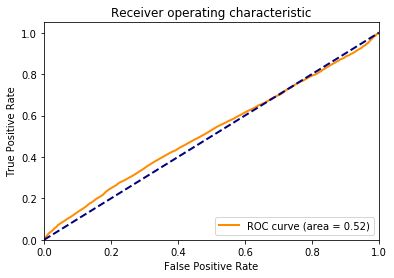

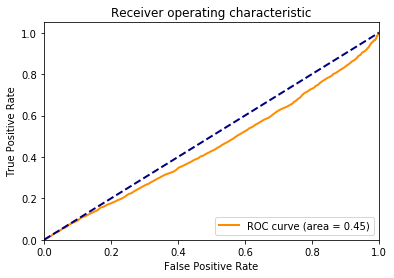

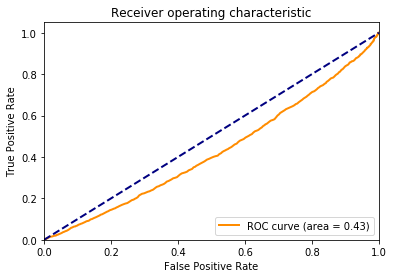

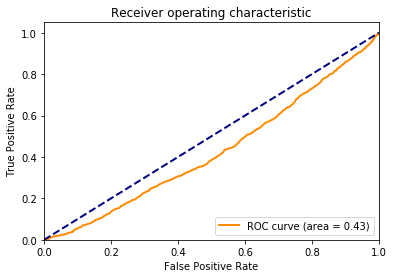

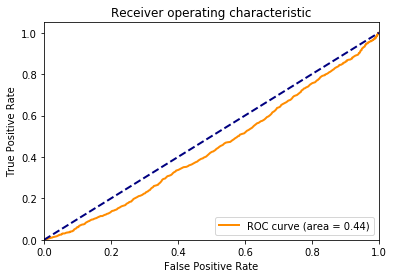

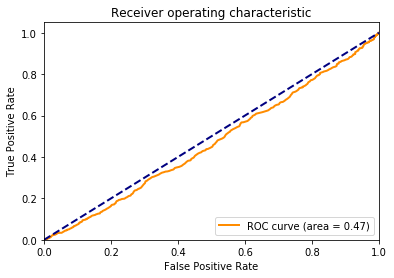

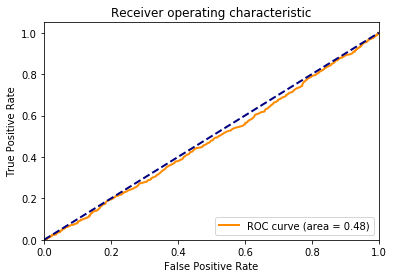

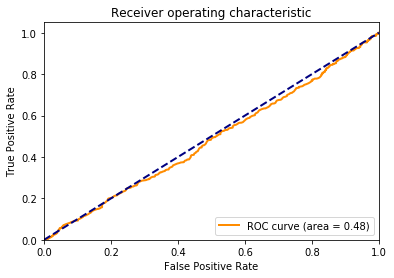

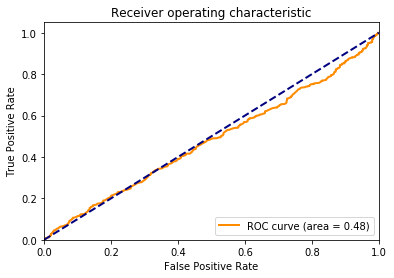

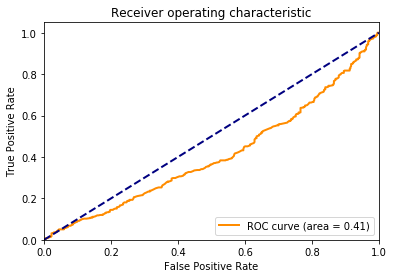

In [27]:
for i in range(10):
    train_epoch(train_loader, model, optimizer)

In [28]:
torch.save(model,'facenet.pkl')

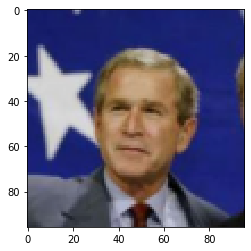

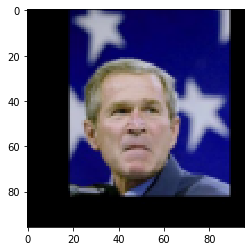

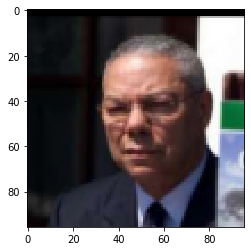

In [137]:
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import transform,data
img_a = io.imread('lfw/test/George_W_Bush/George_W_Bush_0001.jpg') 
img_p = io.imread('lfw/test/George_W_Bush/George_W_Bush_0002.jpg') 
img_n = io.imread('lfw/test/Colin_Powell/Colin_Powell_0003.jpg') 
img_a = transform.resize(img_a, (96, 96))
img_p = transform.resize(img_p, (96, 96))
img_n = transform.resize(img_n, (96, 96))
plt.imshow(img_a)
plt.show()
plt.imshow(img_p)
plt.show()
plt.imshow(img_n)
plt.show()

In [138]:
t = transforms.ToTensor()
img_a = t(img_a)
img_p = t(img_p)
img_n = t(img_n)
test_loader = torch.utils.data.DataLoader([img_a,img_p,img_n])
out = []
for data in test_loader:
    data = torch.tensor(data, dtype=torch.float32)
    out.append(model(data))

<ipython-input-138-0bf4f6d1b66a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


In [139]:
dist1 = l2_dist.forward(out[0],out[1])
dist2 = l2_dist.forward(out[0],out[2])
dist3 = l2_dist.forward(out[1],out[2])
print(dist1,dist2,dist3)

tensor([4.1948], grad_fn=<PowBackward0>) tensor([4.2092], grad_fn=<PowBackward0>) tensor([5.1691], grad_fn=<PowBackward0>)
